In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn import functional as f
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [2]:
batch_size = 128
latent_dim = 20
epochs = 10
learning_rate = 1e-3

In [3]:
transform = transforms.ToTensor()

In [4]:
train_dataset = datasets.MNIST('.', train = True, download = True, transform = transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.37MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc2_mu = nn.Linear(400, latent_dim)
        self.fc2_logvar = nn.Linear(400, latent_dim)

    def forward(self, x):
        x = x.view(-1, 28*28)
        h1 = f.relu(self.fc1(x))
        mu = self.fc2_mu(h1)
        logvar = self.fc2_logvar(h1)
        return mu, logvar

In [7]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 400)
        self.fc2 = nn.Linear(400, 28*28)

    def forward(self, z):
        h1 = f.relu(self.fc1(z))
        x_recon = torch.sigmoid(self.fc2(h1))
        return x_recon.view(-1, 1, 28, 28)

In [8]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [9]:
model = VAE()

In [10]:
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [11]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        recon_loss = f.binary_cross_entropy(recon_batch, data, reduction = 'sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader.dataset):.4f}')
    

Epoch 1/10, Loss: 163.7360
Epoch 2/10, Loss: 121.3420
Epoch 3/10, Loss: 114.5442
Epoch 4/10, Loss: 111.6983
Epoch 5/10, Loss: 109.9739
Epoch 6/10, Loss: 108.7784
Epoch 7/10, Loss: 107.8850
Epoch 8/10, Loss: 107.2813
Epoch 9/10, Loss: 106.7101
Epoch 10/10, Loss: 106.2586


In [16]:
with torch.no_grad():
    z = torch.randn(64, latent_dim)
    generated = model.decoder(z)

In [18]:
generated[0].shape

torch.Size([1, 28, 28])

In [24]:
grid = torchvision.utils.make_grid(generated, nrow = 8, padding = 2, normalize = True)
npimg = grid.numpy()

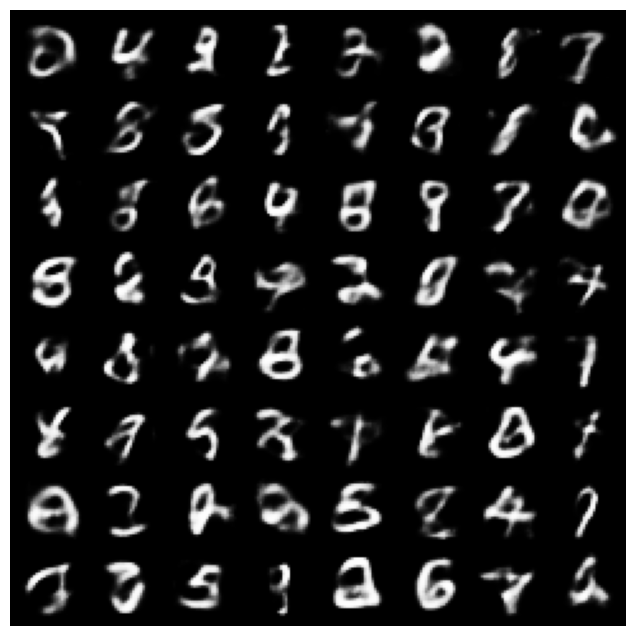

In [25]:
plt.figure(figsize = (8, 8))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.axis('off')
plt.show()